In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy

In [2]:
import numpy as np
import pandas as pd

In [3]:
lower_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower")
upper_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper")

In [4]:
age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
           'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]

In [5]:
data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-06-18-19h00.csv", sep=";")
data.head()

,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0


In [6]:
# Extract days 
days = data[data['reg']==11][data['cl_age90']==0].jour.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [7]:
beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values

icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values

deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/sergioacamelogomez/opt/anaconda3/lib/pyth

In [8]:
mult_deaths = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].dc.values)
print(mult_deaths)
mult_icus = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].rea.values)
print(mult_icus)


1.6686705156872337
6.371596044491136


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from group import SEIR_group, DynamicalModel
from heuristics import *
from fast_group import FastDynamicalModel
from aux import *


In [10]:
region = "Ile-de-France"

In [11]:
# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)
    

In [12]:
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-06-02", '%Y-%m-%d')
date_4 = datetime.strptime("2020-06-15", '%Y-%m-%d')
date_5 = datetime.strptime("2020-06-22", '%Y-%m-%d')
#final_date = datetime.strptime(days[-1], '%Y-%m-%d') + timedelta(days=1)
final_date = datetime.strptime("2020-06-24", '%Y-%m-%d')

In [13]:
from copy import deepcopy

In [15]:
# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, 1.0, mixing_method)


In [16]:
params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower", index_col = 0)
lower_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper", index_col = 0)
upper_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

In [17]:
# Construct the windows for the parameters to move
windows = {}
for p in initial_params:
    windows[p] = (
        np.min(upper_params[p]/initial_params[p]),
        np.max(lower_params[p]/initial_params[p]),
    )
    
windows['beta_mixing'] = (0.1,3.0)
windows['alpha_mixing'] = (0.1,3.0)
windows['gamma_mixing'] = (0.7,1.3)

In [74]:
import copy
best_v = 0
best_error = float('inf')
def error(v):
    days_ahead = v[0]
    alpha_mixing = v[1]
    beta_mixing = v[2]
    gamma_mixing = v[3]
    
    dynModel.mu = v[4]*initial_params["mu"]
    dynModel.sigma = v[5]*initial_params['sigma']
    dynModel.p_H = v[6]*initial_params['p_H']
    dynModel.p_ICU = v[7]*initial_params['p_ICU']
    dynModel.lambda_H_R = v[8]*initial_params['lambda_H_R']
    dynModel.lambda_H_D = v[9]*initial_params['lambda_H_D']
    dynModel.lambda_ICU_R = v[10]*initial_params['lambda_ICU_R']
    dynModel.lambda_ICU_D = v[11]*initial_params['lambda_ICU_D']

    upper_bound = v[12]
    
    delta_transport = v[13]
    delta_school = v[14]

    leisure_1 = v[15]
    leisure_2 = v[16]
    leisure_3 = v[17]
    leisure_4 = v[18]
    leisure_5 = v[19]
    leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

    other_1 = v[20]
    other_2 = v[21]
    other_3 = v[22]
    other_4 = v[23]
    other_5 = v[24]
    other_denom = other_1+other_2+other_3+other_4+other_5
    
    work_1 = v[25]
    work_2 = v[26]
    work_3 = v[27]
    work_4 = v[28]
    work_5 = v[29]
    work_denom = work_1+work_2+work_3+work_4+work_5

    initial = v[30:39]
    
    # Construct initialization
    initialization = copy.deepcopy(original_initialization)
    for i,group in enumerate(age_groups):
        initialization[group]["I"] = initialization[group]["I"] + (v[30+i])
        initialization[group]["S"] = initialization[group]["S"] - (v[30+i])
        initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]

    
    # Alphas
    a_before_date_1 = {
        'home':upper_bound,
        'leisure':upper_bound,
        'other':upper_bound,
        'school':upper_bound,
        'transport':delta_transport*upper_bound,
        'work':upper_bound
    }
    a_between_date_1_2 = {
        'home':upper_bound,
        'leisure':leisure_1/leisure_denom*upper_bound,
        'other':other_1/other_denom*upper_bound,
        'school':0,
        'transport':delta_transport*0.24*work_1/work_denom*upper_bound*upper_bound,
        'work':work_1/work_denom*upper_bound
    }
    a_between_date_2_3 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
        'other':(other_1+other_2)/other_denom*upper_bound,
        'school':0.33*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2)/work_denom*upper_bound,
        'work':(work_1+work_2)/work_denom*upper_bound
    }
    a_between_date_3_4 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3)/work_denom*upper_bound
    }
    a_between_date_4_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }
    a_after_date_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':1.0*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }


    # Determine mixing method
    mixing_method = {
        "name":"mult",
        "param_alpha":alpha_mixing,
        "param_beta":beta_mixing,
        "param_gamma":gamma_mixing,
    }
    dynModel.mixing_method = mixing_method

    # Number of days
    days_before_date_1 = int(days_ahead)
    days_between_dates_1_2 = (date_2-date_1).days
    days_between_dates_2_3 = (date_3-date_2).days
    days_between_dates_3_4 = (date_4-date_3).days
    days_between_dates_4_5 = (date_5-date_4).days
    days_after_date_5 = (final_date-date_5).days
    total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



    # Calculate alphas
    alphas_vec = []
    for t in range(days_before_date_1):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_before_date_1
        alphas_vec.append(alphas)
    for t in range(days_between_dates_1_2):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_1_2
        alphas_vec.append(alphas)
    for t in range(days_between_dates_2_3):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_2_3
        alphas_vec.append(alphas)
    for t in range(days_between_dates_3_4):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_3_4
        alphas_vec.append(alphas)
    for t in range(days_between_dates_4_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_4_5
        alphas_vec.append(alphas)
    for t in range(days_after_date_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_after_date_5
        alphas_vec.append(alphas)

    # Calculate tests
    tests = np.zeros(len(age_groups))
    
    
    # Run model
    model_data_beds = {ag:[] for ag in age_groups+["total"]}
    model_data_icus = {ag:[] for ag in age_groups+["total"]}
    model_data_deaths = {ag:[] for ag in age_groups+["total"]}

    state = state_to_matrix(initialization)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)
    
    for t in range(total_days):
        state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)
            
    
    initial_date = date_1-timedelta(days=days_before_date_1)

    # Calculate the days of the model
    days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

    # Indices where to put the real data
    indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

    # Real data
    real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    
    for k,ind in enumerate(indices):
        for ag in age_groups+["total"]:
            real_data_beds[ag][ind] = beds_real[ag][k]
            real_data_icus[ag][ind] = icus_real[ag][k]
            real_data_deaths[ag][ind] = deaths_real[ag][k]

    error_beds = 0
    error_icus = 0
    error_deaths = 0
    for ag in age_groups:
        error_beds += np.nanmean(np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag])))
        error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
        error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
    error_beds_total = np.nanmean(np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"])))
    error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
    error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))
    
    
    error = error_beds_total
    error = mult_icus*error_icus_total
    error = mult_deaths*error_deaths_total
    error = (error_beds_total + mult_icus*error_icus_total + mult_deaths*error_deaths_total)/3
    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print(best_error)
        best_v = v
        print(v)
    return error





In [75]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution
epsilon = 0.1
result = differential_evolution(error, [(30,120),
                                        windows['alpha_mixing'],windows['beta_mixing'],windows['gamma_mixing'],
                                        windows['mu'],windows['sigma'],windows['p_H'],windows['p_ICU'],
                                        windows['lambda_H_R'],windows['lambda_H_D'],windows['lambda_ICU_R'],windows['lambda_ICU_D']]+
                                        [(0,1)]*18+[(0,2)]*9)




8306.033031840934
[7.84978786e+01 7.19960374e-01 4.39690890e-01 1.21312681e+00
 9.90310679e-01 9.71935419e-01 1.56277675e+00 1.39131254e+00
 1.01069089e+00 1.04320321e+00 1.00967745e+00 1.01658124e+00
 2.22527739e-01 5.28189367e-01 7.26493978e-01 7.44968063e-01
 1.02199887e-01 7.84351746e-01 5.27300545e-01 3.96633136e-01
 8.24243507e-01 2.25729066e-02 6.75906304e-01 7.75285181e-01
 7.76183073e-01 5.78831870e-01 6.69489017e-01 3.76265339e-01
 8.69919264e-01 8.15125586e-01 1.45165191e+00 1.21905947e+00
 1.33527124e+00 1.79569741e+00 1.99226984e+00 1.89904062e-01
 6.33988346e-01 1.30993159e+00 8.36192091e-01]
8289.798344478744
[4.60391376e+01 2.11135982e+00 4.90529094e-01 8.81793892e-01
 9.17256833e-01 9.22166278e-01 8.23709128e-01 9.25961732e-01
 9.86970141e-01 1.00882417e+00 1.02780108e+00 9.72420760e-01
 9.19066668e-01 8.36859030e-01 8.38286363e-01 7.87833478e-01
 6.61314206e-01 5.51975610e-02 2.18381119e-03 9.96777037e-01
 5.51972929e-01 1.31432278e-01 9.94434438e-01 9.15258010e-01
 3

KeyboardInterrupt: 

In [76]:
best_v_grad = 0
best_error = float('inf')
def error_grad(v):
    days_ahead = v[0]
    alpha_mixing = v[1]
    beta_mixing = v[2]
    gamma_mixing = v[3]
    
    dynModel.mu = np.array(v[4:13])
    dynModel.sigma = np.array(v[13:22])
    dynModel.p_H = np.array(v[22:31])
    dynModel.p_ICU = np.array(v[31:40])
    dynModel.lambda_H_R = np.array(v[40:49])
    dynModel.lambda_H_D = np.array(v[49:58])
    dynModel.lambda_ICU_R = np.array(v[58:67])
    dynModel.lambda_ICU_D = np.array(v[67:76])

    
    upper_bound = v[76]
    
    delta_transport = v[77]
    delta_school = v[78]

    leisure_1 = v[79]
    leisure_2 = v[80]
    leisure_3 = v[81]
    leisure_4 = v[82]
    leisure_5 = v[83]
    leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

    other_1 = v[84]
    other_2 = v[85]
    other_3 = v[86]
    other_4 = v[87]
    other_5 = v[88]
    other_denom = other_1+other_2+other_3+other_4+other_5
    
    work_1 = v[89]
    work_2 = v[90]
    work_3 = v[91]
    work_4 = v[92]
    work_5 = v[93]
    work_denom = work_1+work_2+work_3+work_4+work_5

    initial = v[94:103]
    
    # Construct initialization
    initialization = copy.deepcopy(original_initialization)
    for i,group in enumerate(age_groups):
        initialization[group]["I"] = initialization[group]["I"] + (v[94+i])
        initialization[group]["S"] = initialization[group]["S"] - (v[94+i])
        initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


    
    # Alphas
    a_before_date_1 = {
        'home':upper_bound,
        'leisure':upper_bound,
        'other':upper_bound,
        'school':upper_bound,
        'transport':delta_transport*upper_bound,
        'work':upper_bound
    }
    a_between_date_1_2 = {
        'home':upper_bound,
        'leisure':leisure_1/leisure_denom*upper_bound,
        'other':other_1/other_denom*upper_bound,
        'school':0,
        'transport':delta_transport*0.24*work_1/work_denom*upper_bound*upper_bound,
        'work':work_1/work_denom*upper_bound
    }
    a_between_date_2_3 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
        'other':(other_1+other_2)/other_denom*upper_bound,
        'school':0.33*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2)/work_denom*upper_bound,
        'work':(work_1+work_2)/work_denom*upper_bound
    }
    a_between_date_3_4 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3)/work_denom*upper_bound
    }
    a_between_date_4_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':0.67*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }
    a_after_date_5 = {
        'home':upper_bound,
        'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
        'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
        'school':1.0*delta_school*upper_bound,
        'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
        'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
    }



    # Determine mixing method
    mixing_method = {
        "name":"mult",
        "param_alpha":alpha_mixing,
        "param_beta":beta_mixing,
        "param_gamma":gamma_mixing,
    }
    dynModel.mixing_method = mixing_method

    # Number of days
    days_before_date_1 = int(days_ahead)
    days_between_dates_1_2 = (date_2-date_1).days
    days_between_dates_2_3 = (date_3-date_2).days
    days_between_dates_3_4 = (date_4-date_3).days
    days_between_dates_4_5 = (date_5-date_4).days
    days_after_date_5 = (final_date-date_5).days
    total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



    # Calculate alphas
    alphas_vec = []
    for t in range(days_before_date_1):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_before_date_1
        alphas_vec.append(alphas)
    for t in range(days_between_dates_1_2):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_1_2
        alphas_vec.append(alphas)
    for t in range(days_between_dates_2_3):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_2_3
        alphas_vec.append(alphas)
    for t in range(days_between_dates_3_4):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_3_4
        alphas_vec.append(alphas)
    for t in range(days_between_dates_4_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_between_date_4_5
        alphas_vec.append(alphas)
    for t in range(days_after_date_5):
        alphas = {}
        for age_group in age_groups:
            alphas[age_group] = a_after_date_5
        alphas_vec.append(alphas)

    # Calculate tests
    tests = np.zeros(len(age_groups))
    
    
    # Run model
    model_data_beds = {ag:[] for ag in age_groups+["total"]}
    model_data_icus = {ag:[] for ag in age_groups+["total"]}
    model_data_deaths = {ag:[] for ag in age_groups+["total"]}

    state = state_to_matrix(initialization)
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)
    
    for t in range(total_days):
        state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)
            
    
    initial_date = date_1-timedelta(days=days_before_date_1)

    # Calculate the days of the model
    days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

    # Indices where to put the real data
    indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

    # Real data
    real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
    
    for k,ind in enumerate(indices):
        for ag in age_groups+["total"]:
            real_data_beds[ag][ind] = beds_real[ag][k]
            real_data_icus[ag][ind] = icus_real[ag][k]
            real_data_deaths[ag][ind] = deaths_real[ag][k]

    error_beds = 0
    error_icus = 0
    error_deaths = 0
    for ag in age_groups:
        error_beds += np.nanmean(np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag])))
        error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
        error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
    error_beds_total = np.nanmean(np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"])))
    error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
    error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))
    
    
    
    error = error_beds_total
    error = mult_icus*error_icus_total
    error = mult_deaths*error_deaths_total
    error = (error_beds_total + mult_icus*error_icus_total + mult_deaths*error_deaths_total)/3
    
    global best_error
    global best_v_grad
    if error<best_error:
        best_error = error
        print(best_error)
        best_v_grad = v
        print(v)
    return error





In [77]:
v0 = (list(best_v[0:4]) + list(best_v[4]*initial_params["mu"]) + list(best_v[5]*initial_params['sigma']) + list(best_v[6]*initial_params['p_H'])+
      list(best_v[7]*initial_params['p_ICU'])+list(best_v[8]*initial_params['lambda_H_R'])+list(best_v[9]*initial_params['lambda_H_D'])+
    list(best_v[10]*initial_params['lambda_ICU_R'])+list(best_v[11]*initial_params['lambda_ICU_D']) + list(best_v[12:]))
error_grad(v0)

2757.332399675319
[93.9033477223863, 0.49754407000697554, 2.4929565042654676, 0.9664730545699043, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.25177247429512584, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.28010429194850317, 0.001120464268681897, 0.001120464268681897, 0.0038236923307846233, 0.007872773682197418, 0.009523946283796126, 0.018247149465552233, 0.035379595404163855, 0.061109228298940756, 0.217525608151303, 0.0003325798695023014, 0.0003325798695023014, 0.0005168470944968197, 0.0015482941222100385, 0.002826928890769562, 0.007235859322955477, 0.016380307626748483, 0.02107612564906814, 0.013423043381714508, 0.06688106483949291, 0.06688106483949291, 0.06654464097209102, 0.06600636278424803, 0.06506437595552277, 0.06291126320415077, 0

2757.332399675319

In [78]:
lb= ([30,windows['alpha_mixing'][0],windows['beta_mixing'][0],windows['gamma_mixing'][0]]+
                list(lower_params['mu'])+list(lower_params['sigma'])+list(lower_params['p_H'])+list(lower_params['p_ICU'])+
                list(lower_params['lambda_H_R'])+list(lower_params['lambda_H_D'])+list(lower_params['lambda_ICU_R'])+list(lower_params['lambda_ICU_D'])+
                [0]*18+[0]*9)
ub = ([120,windows['alpha_mixing'][1],windows['beta_mixing'][1],windows['gamma_mixing'][1]]+
                list(upper_params['mu'])+list(upper_params['sigma'])+list(upper_params['p_H'])+list(upper_params['p_ICU'])+
                list(upper_params['lambda_H_R'])+list(upper_params['lambda_H_D'])+list(upper_params['lambda_ICU_R'])+list(upper_params['lambda_ICU_D'])+
                [1]*18+[5]*9)
for i in range(len(v0)):
    assert(v0[i]>=lb[i])
    assert(ub[i]>=v0[i])

In [79]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution

bounds = Bounds(lb,ub)

result = minimize(error_grad, v0, bounds = bounds)

2757.3319918133625
[9.39033477e+01 4.97544070e-01 2.49295650e+00 9.66473065e-01
 2.51772474e-01 2.51772474e-01 2.51772474e-01 2.51772474e-01
 2.51772474e-01 2.51772474e-01 2.51772474e-01 2.51772474e-01
 2.51772474e-01 2.80104292e-01 2.80104292e-01 2.80104292e-01
 2.80104292e-01 2.80104292e-01 2.80104292e-01 2.80104292e-01
 2.80104292e-01 2.80104292e-01 1.12046427e-03 1.12046427e-03
 3.82369233e-03 7.87277368e-03 9.52394628e-03 1.82471495e-02
 3.53795954e-02 6.11092283e-02 2.17525608e-01 3.32579870e-04
 3.32579870e-04 5.16847094e-04 1.54829412e-03 2.82692889e-03
 7.23585932e-03 1.63803076e-02 2.10761256e-02 1.34230434e-02
 6.68810648e-02 6.68810648e-02 6.65446410e-02 6.60063628e-02
 6.50643760e-02 6.29112632e-02 5.88068920e-02 5.31549710e-02
 4.60227851e-02 3.94495038e-04 3.94495038e-04 7.23240903e-04
 1.24923429e-03 2.16972271e-03 4.27369625e-03 8.28439580e-03
 1.38073263e-02 2.07767387e-02 4.51188787e-02 4.51188787e-02
 4.48919226e-02 4.45287928e-02 4.38933156e-02 4.24407964e-02
 3.96

2647.1237771371766
[9.39033477e+01 4.96413864e-01 2.48615340e+00 9.67421262e-01
 2.51698447e-01 2.51698447e-01 2.51698447e-01 2.51698447e-01
 2.51698447e-01 2.51698447e-01 2.51698447e-01 2.51698447e-01
 2.51698447e-01 2.80115626e-01 2.80115626e-01 2.80115626e-01
 2.80115626e-01 2.80115626e-01 2.80115626e-01 2.80115626e-01
 2.80115626e-01 2.79942555e-01 1.12526188e-03 1.12526188e-03
 3.84010283e-03 7.90393044e-03 9.56765996e-03 1.83329726e-02
 3.55561564e-02 6.13871110e-02 2.18282988e-01 3.33819227e-04
 3.33809227e-04 5.19130435e-04 1.55372905e-03 2.83693066e-03
 7.25934835e-03 1.64331860e-02 2.11445670e-02 1.34677433e-02
 6.68740840e-02 6.68740840e-02 6.65380598e-02 6.60000130e-02
 6.50581062e-02 6.29049908e-02 5.88007827e-02 5.31489707e-02
 4.60173906e-02 3.95913612e-04 3.95913612e-04 7.24311041e-04
 1.25017679e-03 2.17078380e-03 4.27522378e-03 8.28663541e-03
 1.38106682e-02 2.07809784e-02 4.51147669e-02 4.51147669e-02
 4.48880786e-02 4.45251006e-02 4.38896689e-02 4.24371279e-02
 3.96

KeyboardInterrupt: 

In [80]:
v = best_v_grad

days_ahead = v[0]
alpha_mixing = v[1]
beta_mixing = v[2]
gamma_mixing = v[3]

dynModel.mu = np.array(v[4:13])
dynModel.sigma = np.array(v[13:22])
dynModel.p_H = np.array(v[22:31])
dynModel.p_ICU = np.array(v[31:40])
dynModel.lambda_H_R = np.array(v[40:49])
dynModel.lambda_H_D = np.array(v[49:58])
dynModel.lambda_ICU_R = np.array(v[58:67])
dynModel.lambda_ICU_D = np.array(v[67:76])


upper_bound = v[76]

delta_transport = v[77]
delta_school = v[78]

leisure_1 = v[79]
leisure_2 = v[80]
leisure_3 = v[81]
leisure_4 = v[82]
leisure_5 = v[83]
leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

other_1 = v[84]
other_2 = v[85]
other_3 = v[86]
other_4 = v[87]
other_5 = v[88]
other_denom = other_1+other_2+other_3+other_4+other_5

work_1 = v[89]
work_2 = v[90]
work_3 = v[91]
work_4 = v[92]
work_5 = v[93]
work_denom = work_1+work_2+work_3+work_4+work_5

initial = v[94:103]

# Construct initialization
initialization = copy.deepcopy(original_initialization)
for i,group in enumerate(age_groups):
    initialization[group]["I"] = initialization[group]["I"] + (v[94+i])
    initialization[group]["S"] = initialization[group]["S"] - (v[94+i])
    initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]



# Alphas
a_before_date_1 = {
    'home':upper_bound,
    'leisure':upper_bound,
    'other':upper_bound,
    'school':upper_bound,
    'transport':delta_transport*upper_bound,
    'work':upper_bound
}
a_between_date_1_2 = {
    'home':upper_bound,
    'leisure':leisure_1/leisure_denom*upper_bound,
    'other':other_1/other_denom*upper_bound,
    'school':0,
    'transport':delta_transport*0.24*work_1/work_denom*upper_bound*upper_bound,
    'work':work_1/work_denom*upper_bound
}
a_between_date_2_3 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
    'other':(other_1+other_2)/other_denom*upper_bound,
    'school':0.33*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2)/work_denom*upper_bound,
    'work':(work_1+work_2)/work_denom*upper_bound
}
a_between_date_3_4 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2+work_3)/work_denom*upper_bound,
    'work':(work_1+work_2+work_3)/work_denom*upper_bound
}
a_between_date_4_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
    'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
}
a_after_date_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':1.0*delta_school*upper_bound,
    'transport':delta_transport*(work_1+work_2+work_3+work_4)/work_denom*upper_bound,
    'work':(work_1+work_2+work_3+work_4)/work_denom*upper_bound
}



# Determine mixing method
mixing_method = {
    "name":"mult",
    "param_alpha":alpha_mixing,
    "param_beta":beta_mixing,
    "param_gamma":gamma_mixing,
}
dynModel.mixing_method = mixing_method

# Number of days
days_before_date_1 = int(days_ahead)
days_between_dates_1_2 = (date_2-date_1).days
days_between_dates_2_3 = (date_3-date_2).days
days_between_dates_3_4 = (date_4-date_3).days
days_between_dates_4_5 = (date_5-date_4).days
days_after_date_5 = (final_date-date_5).days
total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5 + days_after_date_5



# Calculate alphas
alphas_vec = []
for t in range(days_before_date_1):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_before_date_1
    alphas_vec.append(alphas)
for t in range(days_between_dates_1_2):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_1_2
    alphas_vec.append(alphas)
for t in range(days_between_dates_2_3):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_2_3
    alphas_vec.append(alphas)
for t in range(days_between_dates_3_4):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_3_4
    alphas_vec.append(alphas)
for t in range(days_between_dates_4_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_between_date_4_5
    alphas_vec.append(alphas)
for t in range(days_after_date_5):
    alphas = {}
    for age_group in age_groups:
        alphas[age_group] = a_after_date_5
    alphas_vec.append(alphas)

# Calculate tests
tests = np.zeros(len(age_groups))


# Run model
model_data_beds = {ag:[] for ag in age_groups+["total"]}
model_data_icus = {ag:[] for ag in age_groups+["total"]}
model_data_deaths = {ag:[] for ag in age_groups+["total"]}

state = state_to_matrix(initialization)
t_beds = 0
t_icus = 0
t_deaths = 0
for i,ag in enumerate(age_groups):
    state_H = state[i,cont.index("H")]
    state_ICU = state[i,cont.index("ICU")]
    state_D = state[i,cont.index("D")]
    model_data_beds[ag].append(state_H)
    model_data_icus[ag].append(state_ICU)
    model_data_deaths[ag].append(state_D)
    t_beds+= state_H
    t_icus+= state_ICU
    t_deaths+= state_D
model_data_beds["total"].append(t_beds)
model_data_icus["total"].append(t_icus)
model_data_deaths["total"].append(t_deaths)

for t in range(total_days):
    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
    t_beds = 0
    t_icus = 0
    t_deaths = 0
    for i,ag in enumerate(age_groups):
        state_H = state[i,cont.index("H")]
        state_ICU = state[i,cont.index("ICU")]
        state_D = state[i,cont.index("D")]
        model_data_beds[ag].append(state_H)
        model_data_icus[ag].append(state_ICU)
        model_data_deaths[ag].append(state_D)
        t_beds+= state_H
        t_icus+= state_ICU
        t_deaths+= state_D
    model_data_beds["total"].append(t_beds)
    model_data_icus["total"].append(t_icus)
    model_data_deaths["total"].append(t_deaths)


initial_date = date_1-timedelta(days=days_before_date_1)

# Calculate the days of the model
days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

# Indices where to put the real data
indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

# Real data
real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

for k,ind in enumerate(indices):
    for ag in age_groups+["total"]:
        real_data_beds[ag][ind] = beds_real[ag][k]
        real_data_icus[ag][ind] = icus_real[ag][k]
        real_data_deaths[ag][ind] = deaths_real[ag][k]

error_beds = 0
error_icus = 0
error_deaths = 0
for ag in age_groups:
    error_beds += np.nanmean(np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag])))
    error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
    error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
error_beds_total = np.nanmean(np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"])))
error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))



error = error_beds_total
error = mult_icus*error_icus_total
error = mult_deaths*error_deaths_total
error = (error_beds_total + mult_icus*error_icus_total + mult_deaths*error_deaths_total)/3
print(error)

2647.1237771371766


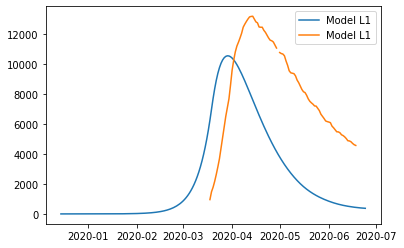

In [81]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data_beds["total"], label="Model L1")
plt.plot(days_model, real_data_beds["total"], label="Model L1")
plt.legend(loc='upper right')

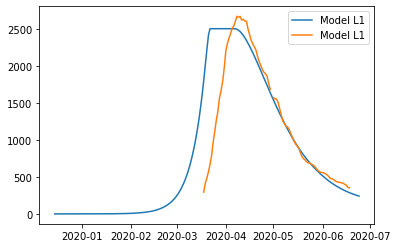

In [82]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data_icus["total"], label="Model L1")
plt.plot(days_model, real_data_icus["total"], label="Model L1")
plt.legend(loc='upper right')

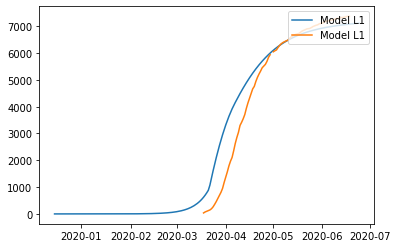

In [83]:
%matplotlib inline
plt.figure(1)
plt.plot(days_model, model_data_deaths["total"], label="Model L1")
plt.plot(days_model, real_data_deaths["total"], label="Model L1")
plt.legend(loc='upper right')

In [102]:
with open("../initialization/initialization.yaml") as file:
    initialization = yaml.load(file, Loader=yaml.FullLoader)
with open("../parameters/Ile-de-France.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)


In [103]:
ays_ahead = v[0]
alpha_mixing = v[1]
beta_mixing = v[2]
gamma_mixing = v[3]

dynModel.mu = np.array(v[4:13])
dynModel.sigma = np.array(v[13:22])
dynModel.p_H = np.array(v[22:31])
dynModel.p_ICU = np.array(v[31:40])
dynModel.lambda_H_R = np.array(v[40:49])
dynModel.lambda_H_D = np.array(v[49:58])
dynModel.lambda_ICU_R = np.array(v[58:67])
dynModel.lambda_ICU_D = np.array(v[67:76])

upper_bound = v[76]

delta_transport = v[77]
delta_work = v[78]
delta_school = v[79]

leisure_1 = v[80]
leisure_2 = v[81]
leisure_3 = v[82]
leisure_4 = v[83]
leisure_5 = v[84]
leisure_denom = leisure_1+leisure_2+leisure_3+leisure_4+leisure_5

other_1 = v[85]
other_2 = v[86]
other_3 = v[87]
other_4 = v[88]
other_5 = v[89]
other_denom = other_1+other_2+other_3+other_4+other_5

In [105]:
# Modify parameters
universe_params['mixing'] = {
    "name":"mult",
    "param_alpha":alpha_mixing,
    "param_beta":beta_mixing,
}
for i,age_group in enumerate(age_groups):
    universe_params['seir-groups'][age_group]['parameters']['beta'] = universe_params['seir-groups'][age_group]['parameters']['beta']*gamma_mixing
    universe_params['seir-groups'][age_group]['parameters']['mu'] = v[4+i]
    universe_params['seir-groups'][age_group]['parameters']['sigma'] = v[13+i]
    universe_params['seir-groups'][age_group]['parameters']['p_H'] = v[22+i]
    universe_params['seir-groups'][age_group]['parameters']['p_ICU'] = v[31+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_H_R'] = v[40+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_H_D'] = v[49+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_ICU_R'] = v[58+i]
    universe_params['seir-groups'][age_group]['parameters']['lambda_ICU_D'] = v[67+i]
    
with open('../parameters/fitted.yaml', 'w') as file:
    yaml.dump(universe_params, file)
    

In [107]:
# Add economic value parameters
contrib = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="contributions_normal", index_col = 0)
drops = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="activity_levels_as_%_of_full", index_col = 0)

empl_params = {}
empl_params["v"] = {}
for age_group in age_groups:
    empl_params["v"][age_group] = {}
    for activity in econ_activities:
        empl_params["v"][age_group][activity] = float(contrib[age_group][activity])/365.0


In [108]:
# Calculate l-april and l-may
l_april = a_between_date_1_2
l_may = {}
for a in a_between_date_1_2.keys():
    l_may[a] = a_between_date_1_2[a]/3.0 + a_between_date_2_3[a]*2.0/3.0

In [109]:
l_april

{'home': 0.984925391,
 'leisure': 0.02911777197632741,
 'other': 0.11455320515166358,
 'school': 0,
 'transport': 0.010853963467638622,
 'work': 0.11620826067947282}

In [110]:
l_may

{'home': 0.984925391,
 'leisure': 0.18858209267922665,
 'other': 0.14621578568939403,
 'school': 0.11745997287022852,
 'transport': 0.033767886343764604,
 'work': 0.3615368110028043}

In [73]:
from gurobipy import *
# Solve equations
empl_params["nu"] = {}
empl_params["eta"] = {}
empl_params["gamma"] = {}
for activity in econ_activities:
    m = Model()
    nu = m.addVar(vtype=GRB.CONTINUOUS, name="nu", lb = 0)
    eta = m.addVar(vtype=GRB.CONTINUOUS, name="eta", lb = 0)
    gamma = m.addVar(vtype=GRB.CONTINUOUS, name="gamma", lb = 0)
    epsilonp_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_1", lb = 0)
    epsilonn_1 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_1", lb = 0)
    epsilonp_2 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonp_2", lb = 0)
    epsilonn_2 = m.addVar(vtype=GRB.CONTINUOUS, name="epsilonn_2", lb = 0)
    
    m.addConstr(nu+eta+gamma==1)
    m.addConstr(
        nu*l_april["work"] + eta*l_april[activity] + gamma == drops[activity]["April"]+epsilonp_1-epsilonn_1
    )
    m.addConstr(
        nu*l_may["work"] + eta*l_may[activity] + gamma == drops[activity]["May"]+epsilonp_2-epsilonn_2
    )
    m.setObjective(epsilonp_1+epsilonn_1+epsilonp_2+epsilonn_2)
    m.update()
    m.optimize()
    empl_params["nu"][activity] = float(nu.x)
    empl_params["eta"][activity] = float(eta.x)
    empl_params["gamma"][activity] = float(gamma.x)
    


Using license file /Users/sergioacamelogomez/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 3 rows, 7 columns and 13 nonzeros
Model fingerprint: 0x241add63
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+00]
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 13 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.422549e-01   0.000000e+00      0s
       2    9.1741311e-02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  9.174131148e-02
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 3 rows, 7 columns and 13 nonzeros
Model fingerprint: 0x8ee73c76
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+0

In [111]:
from gurobipy import *
# Solve equations
empl_params["nu"] = {}
empl_params["eta"] = {}
empl_params["gamma"] = {}
for activity in econ_activities:
    A = np.array([
        [1,1,1],
        [l_april["work"],l_april[activity],1],
        [l_may["work"],l_may[activity],1]
    ])
    b = np.array([1,drops[activity]["April"],drops[activity]["May"]])
    print("Activity:",activity)
    print("A=",A)
    print("b=",b)
    print("nu,eta,gamma=",np.linalg.solve(A,b))
    print("")


Activity: transport
A= [[1.         1.         1.        ]
 [0.11620826 0.01085396 1.        ]
 [0.36153681 0.03376789 1.        ]]
b= [1.   0.61 0.81]
nu,eta,gamma= [ 0.84928217 -0.36454533  0.51526316]

Activity: leisure
A= [[1.         1.         1.        ]
 [0.11620826 0.02911777 1.        ]
 [0.36153681 0.18858209 1.        ]]
b= [1.    0.313 0.426]
nu,eta,gamma= [0.0016216  0.70612771 0.29225069]

Activity: other
A= [[1.         1.         1.        ]
 [0.11620826 0.11455321 1.        ]
 [0.36153681 0.14621579 1.        ]]
b= [1.    0.625 0.753]
nu,eta,gamma= [ 0.53615787 -0.11164069  0.57548283]



In [112]:
# Calculate the schooling parameter
r = 0.03
schooling_param = {}
for age_group in age_groups:
    if age_group == "age_group_0_9":
        schooling_param[age_group] = (1+r)**(-15)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    elif age_group == "age_group_10_19":
        schooling_param[age_group] = 0.907*(1+r)**(-5)*sum([empl_params["v"]["age_group_20_29"][act] for act in econ_activities])
    else:
        schooling_param[age_group] = 0

In [113]:
# Calculate the cost of death
econ_cost_death = {}
age_groups_n = [0,10,20,30,40,50,60,70,80]
for i,age_group in enumerate(age_groups):
    s = 0
    for tao in range(age_groups_n[i]+5,70):
        ag = "age_group_%d_%d"%(int(tao/10)*10,int(tao/10)*10+9)
        s+=(1+r)**(-(tao-age_groups_n[i]))*sum([empl_params["v"][ag][act] for act in econ_activities])*365
    econ_cost_death[age_group] = float(s)

In [114]:
econ_params = {
    "employment_params":empl_params,
    "schooling_params":schooling_param,
    "econ_cost_death":econ_cost_death,
}
with open('../parameters/econ.yaml', 'w') as file:
    yaml.dump(econ_params, file)

In [115]:
print(econ_params)

{'employment_params': {'v': {'age_group_0_9': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}, 'age_group_10_19': {'transport': 0.42995936063784673, 'leisure': 0.7068903576182438, 'other': 4.574913439411911}, 'age_group_20_29': {'transport': 2.421870523023006, 'leisure': 3.981764503475539, 'other': 25.769523863503046}, 'age_group_30_39': {'transport': 5.3207402525299345, 'leisure': 8.74775693759741, 'other': 56.61448108213707}, 'age_group_40_49': {'transport': 6.5473065780407085, 'leisure': 10.764338009809762, 'other': 69.6655628368981}, 'age_group_50_59': {'transport': 6.717886370840974, 'leisure': 11.04478593529775, 'other': 71.48058969296267}, 'age_group_60_69': {'transport': 2.606993951947998, 'leisure': 4.286123424007397, 'other': 27.739299941136395}, 'age_group_70_79': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}, 'age_group_80_plus': {'transport': 0.0, 'leisure': 0.0, 'other': 0.0}}, 'nu': {}, 'eta': {}, 'gamma': {}}, 'schooling_params': {'age_group_0_9': 20.65072641904043,

In [116]:
# Initialization

# Run model
model_data = []
state = initial_state
model_data.append(np.sum(state[:,cont.index("H")]))

for t in range(days_before_date_1):
    state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]))
    model_data.append(np.sum(state[:,cont.index("H")]))


In [117]:
def matrix_to_state(m):
    state = {}
    for i,age_group in enumerate(age_groups):
        state[age_group] = {}
        for j,c in enumerate(cont):
            state[age_group][c] = float(m[i,j])
    return state

with open('../initialization/fitted.yaml', 'w') as file:
    yaml.dump(matrix_to_state(state), file)
    

In [ ]:
a_before_date_1 = {
    'home':upper_bound,
    'leisure':upper_bound,
    'other':upper_bound,
    'school':upper_bound,
    'transport':delta_transport*upper_bound,
    'work':upper_bound
}
a_between_date_1_2 = {
    'home':upper_bound,
    'leisure':leisure_1/leisure_denom*upper_bound,
    'other':other_1/other_denom*upper_bound,
    'school':0,
    'transport':delta_transport*0.24*delta_work*upper_bound,
    'work':0.24*delta_work*upper_bound
}
a_between_date_2_3 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
    'other':(other_1+other_2)/other_denom*upper_bound,
    'school':0.33*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}
a_between_date_3_4 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}
a_between_date_4_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}
a_after_date_5 = {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':1.0*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound
}


In [119]:
# Construct alphas
alphas = []

c = 0
# Alphas
for i in range(days_before_date_1):
    alphas.append( {
    'home':upper_bound,
    'leisure':upper_bound,
    'other':upper_bound,
    'school':upper_bound,
    'transport':delta_transport*upper_bound,
    'work':upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_1_2):
    alphas.append( {
    'home':upper_bound,
    'leisure':leisure_1/leisure_denom*upper_bound,
    'other':other_1/other_denom*upper_bound,
    'school':0,
    'transport':delta_transport*0.24*delta_work*upper_bound,
    'work':0.24*delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_2_3):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2)/leisure_denom*upper_bound,
    'other':(other_1+other_2)/other_denom*upper_bound,
    'school':0.33*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_3_4):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_between_dates_4_5):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':0.67*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1
for i in range(days_after_date_5):
    alphas.append( {
    'home':upper_bound,
    'leisure':(leisure_1+leisure_2+leisure_3+leisure_4)/leisure_denom*upper_bound,
    'other':(other_1+other_2+other_3+other_4)/other_denom*upper_bound,
    'school':1.0*delta_school*upper_bound,
    'transport':delta_transport*delta_work*upper_bound,
    'work':delta_work*upper_bound,
    'date': (initial_date + timedelta(days=c)).strftime('%Y-%m-%d'),
    'days_from_lockdown':c-days_before_date_1
    })
    c+=1

with open('../policies/fitted.yaml', 'w') as file:
    yaml.dump(alphas, file)